<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#TL;DR" data-toc-modified-id="TL;DR-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>TL;DR</a></span></li><li><span><a href="#Import-libs" data-toc-modified-id="Import-libs-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import libs</a></span></li><li><span><a href="#Step-by-step" data-toc-modified-id="Step-by-step-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Step-by-step</a></span><ul class="toc-item"><li><span><a href="#Debug" data-toc-modified-id="Debug-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Debug</a></span></li><li><span><a href="#Run" data-toc-modified-id="Run-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Run</a></span></li></ul></li><li><span><a href="#Pipeline" data-toc-modified-id="Pipeline-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Pipeline</a></span><ul class="toc-item"><li><span><a href="#Traffic-poisson_exp_compute_2e6" data-toc-modified-id="Traffic-poisson_exp_compute_2e6-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Traffic poisson_exp_compute_2e6</a></span><ul class="toc-item"><li><span><a href="#Choose-samples-for-1lb" data-toc-modified-id="Choose-samples-for-1lb-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Choose samples for 1lb</a></span></li></ul></li><li><span><a href="#Run-heuristics" data-toc-modified-id="Run-heuristics-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Run heuristics</a></span></li><li><span><a href="#Run-maglev" data-toc-modified-id="Run-maglev-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Run maglev</a></span></li><li><span><a href="#Run-nf-llf" data-toc-modified-id="Run-nf-llf-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Run nf-llf</a></span></li><li><span><a href="#Run-nf-po2" data-toc-modified-id="Run-nf-po2-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Run nf-po2</a></span></li><li><span><a href="#Run-weighted" data-toc-modified-id="Run-weighted-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Run weighted</a></span></li></ul></li></ul></div>

# TL;DR
This notebook is used to do unit test for each candidate load balancing method implemented for testbed.


# Import libs

In [1]:
import sys
import os
utils_dir = '../../src/utils'
sys.path.insert(0, utils_dir) # add utils dir to path
import testbed_utils as tu
import time

# Step-by-step

## Debug

In [30]:
tu.umount_image()

In [29]:
tu.mount_image(tu.CONF['global']['path']['orig_img'])

In [7]:
tu.umount_image()
# mount base image
tu.mount_new_image(tu.CONF['global']['path']['orig_img'], tu.CONF['global']['path']['base_img'])

In [81]:
img = tu.CONF['global']['path']['base_img']
cmd = "sudo modprobe nbd max_part=8;\
    sudo qemu-nbd --connect=/dev/nbd0 {};\
    sudo mount -o loop /dev/nbd0p1 {};\
    \n".format(img, tu.LOOP_DIR)
print(cmd)

sudo modprobe nbd max_part=8;    sudo qemu-nbd --connect=/dev/nbd0 /home/yzy/Load-Balancer/data/img/lb-vpp-base.img;    sudo mount -o loop /dev/nbd0p1 /mnt/loop;    



In [84]:
cmd = "sudo chown 1000:1000 {0}/home/cisco/*;\
        sudo umount {0}/;\
        sudo qemu-nbd --disconnect /dev/nbd0;\n".format(tu.LOOP_DIR)
print(cmd)

sudo chown 1000:1000 /mnt/loop/home/cisco/*;        sudo umount /mnt/loop/;        sudo qemu-nbd --disconnect /dev/nbd0;



## Unit test

In [2]:
lb_method = 'rlb-sac-new'
trace='wiki_600'
experiment='atc-lb'
sample='hour4.csv'
from_orig=None
config_file_prefix='1lb-conf01'
colocate=None
colocate_freq=0.0001
twist=False
clip_n=10000
remote_servers = [0]
eps = range(3)

In [3]:
server_id = 1
if twist:
    config_file_prefix += '-twist'
config_file = config_file_prefix+'-'+str(server_id)
# config_file_remote = {i: config_file_prefix+'-{}'.format(i) for i in [0, 2, 3]}
config_file_remote = {i: config_file_prefix+'-{}'.format(i) for i in remote_servers}

ip_remote = tu.COMMON_CONF['net']['physical_server_ip']


task_name, task_dir, nodes = tu.init_task_info(
    experiment=experiment,
    lb_method=lb_method,
    trace=trace,
    sample=sample,
    filename=config_file+'.json',
    colocate=colocate,
    colocate_freq=colocate_freq,
    alias=config_file_prefix
)

print(">> run task {}".format(task_name))

init_task_info: alias=1lb-conf01
alias=1lb-conf01
>> run task wiki_600-rlb-sac-new-hour4-1lb-conf01


In [165]:
for server_id in remote_servers:
    if clip_n and server_id == 0:
        clip_str = '-n {}'.format(clip_n)
    else:
        clip_str = ''
    
    cmd = 'ssh -t yzy@{} "python3 /home/yzy/Load-Balancer/src/utils/run2server.py --experiment {} --colocate-freq {} -m {} --tr {} --sample {} -f {}.json {}"'.format(
        ip_remote[server_id], experiment, colocate_freq, 'ecmp', trace, sample, config_file_remote[server_id], clip_str)
    
    tu.subprocess.Popen(cmd, shell=True)

In [166]:
tu.prepare_img(lb_method=lb_method, from_orig=None, debug_node=False)

tu.runall()
time.sleep(10)

Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
node_server_0 ready: ssh -p 9000 cisco@localhost
node_server_1 ready: ssh -p 9001 cisco@localhost
node_server_2 ready: ssh -p 9002 cisco@localhost
node_server_3 ready: ssh -p 9003 cisco@localhost
node_server_4 ready: ssh -p 9004 cisco@localhost
node_server_5 ready: ssh -p 9005 cisco@localhost
node_server_6 ready: ssh -p 9006 cisco@localhost


In [167]:
ep = 0
print("== episode {} ==".format(ep))
net_ok = False
while not net_ok:
    try:
        tu.gt_socket_check()
        net_ok = True
    except:
        print('error')
        time.sleep(1)


== episode 0 ==
LB Node 0: pass


In [168]:
# start gathering at LB node
for lb in tu.NODES['lb']:
    lb.run_init_bg()

In [169]:
# run traffic
t0 = time.time()
cmd = 'ssh -t yzy@10.60.16.12 "python3 /home/yzy/Load-Balancer/src/utils/run_traffic.py --experiment {} --colocate-freq {} -m {} --tr {} --sample {} -f {}.json"'.format(
    experiment, colocate_freq, lb_method, trace, sample, config_file_remote[0])
if colocate:
    cmd += ' --colocate {}'.format(colocate)

tu.subprocess_cmd(cmd)
print("Trace replay over w/ total time: {:.3f}s".format(time.time()-t0))
# time.sleep(5)

# fetch results from nodes
for server_id in remote_servers:
    cmd = 'ssh -t yzy@{} "python3 /home/yzy/Load-Balancer/src/utils/shutdown2server.py --experiment {} --colocate-freq {} -m {} --tr {} --sample {} -f {}.json --episode {}"'.format(
        ip_remote[server_id], experiment, colocate_freq, lb_method, trace, sample, config_file_remote[server_id], 1)
    if ep == eps[-1]:
        cmd += ' --shutdown'
    tu.subprocess.Popen(cmd, shell=True)


Trace replay over w/ total time: 20.793s


In [8]:
# run different episodes
for ep in [2]:
    print("== episode {} ==".format(ep))
    net_ok = False
    while not net_ok:
        try:
            tu.gt_socket_check()
            net_ok = True
        except:
            print('error')
            time.sleep(1)
    # start gathering at LB node
    for lb in tu.NODES['lb']:
        lb.run_init_bg()
        
    # run traffic
    t0 = time.time()
    cmd = 'ssh -t yzy@10.60.16.12 "python3 /home/yzy/Load-Balancer/src/utils/run_traffic.py --experiment {} --colocate-freq {} -m {} --tr {} --sample {} -f {}.json"'.format(
        experiment, colocate_freq, lb_method, trace, sample, config_file_remote[0])
    if colocate:
        cmd += ' --colocate {}'.format(colocate)

    tu.subprocess_cmd(cmd)
    print("Trace replay over w/ total time: {:.3f}s".format(time.time()-t0))
    # time.sleep(5)
    
    # fetch results from nodes
    for server_id in remote_servers:
        cmd = 'ssh -t yzy@{} "python3 /home/yzy/Load-Balancer/src/utils/shutdown2server.py --experiment {} --colocate-freq {} -m {} --tr {} --sample {} -f {}.json --episode {}"'.format(
            ip_remote[server_id], experiment, colocate_freq, lb_method, trace, sample, config_file_remote[server_id], 1)
        if ep == eps[-1]:
            cmd += ' --shutdown'
        tu.subprocess.Popen(cmd, shell=True)
    
    for lb in tu.NODES['lb']:
        lb.fetch_result(task_dir, ep)
        if 'rlb' in lb_method:
            lb.fetch_result(task_dir, ep, filename='rl')
        lb.shutdown()
        
    tu.prepare_img(lb_method=lb_method, from_orig=None, debug_node=False)
    for lb in tu.NODES['lb']:
        lb.run()
    tu.host_br_up()
    # copy rl model
    if 'rlb' in lb_method:
        for lb in tu.NODES['lb']:
            cmd = 'scp -i ~/.ssh/lb_rsa -oStrictHostKeyChecking=no -P {0} -r {1}/{3}_{2}_ep{5} cisco@{4}:~/{2};'.format(
                lb.ssh_port, task_dir, 'rl', lb.id, lb.physical_server_ip, ep)
            tu.subprocess_cmd(cmd)

== episode 2 ==
LB Node 0: pass
Trace replay over w/ total time: 17.424s
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost


In [287]:
# fetch results from nodes
for server_id in remote_servers:
    cmd = 'ssh -t yzy@{} "python3 /home/yzy/Load-Balancer/src/utils/shutdown2server.py --experiment {} --colocate-freq {} -m {} --tr {} --sample {} -f {}.json --episode {}"'.format(
        ip_remote[server_id], experiment, colocate_freq, lb_method, trace, sample, config_file_remote[server_id], 1)
    cmd += ' --shutdown'
    tu.subprocess.Popen(cmd, shell=True)



In [288]:
tu.shutall()

# Pipeline

In [175]:
def run_pipeline(
    lb_method = 'wcmp',
    trace='wiki_600',
    experiment='atc-lb',
    sample='hour0.csv',
    from_orig=True,
    config_file_prefix='1lb-conf01',
    colocate=None,
    colocate_freq=0.0001,
    twist=False,
    clip_n=20000,
    remote_servers = [0],
    eps = range(3)):
    server_id = 1
    if twist:
        config_file_prefix += '-twist'
    config_file = config_file_prefix+'-'+str(server_id)
    # config_file_remote = {i: config_file_prefix+'-{}'.format(i) for i in [0, 2, 3]}
    config_file_remote = {i: config_file_prefix+'-{}'.format(i) for i in remote_servers}

    ip_remote = tu.COMMON_CONF['net']['physical_server_ip']


    task_name, task_dir, nodes = tu.init_task_info(
        experiment=experiment,
        lb_method=lb_method,
        trace=trace,
        sample=sample,
        filename=config_file+'.json',
        colocate=colocate,
        colocate_freq=colocate_freq,
        alias=config_file_prefix
    )

    print(">> run task {}".format(task_name))
    
    for server_id in remote_servers:
        if clip_n and server_id == 0:
            clip_str = '-n {}'.format(clip_n)
        else:
            clip_str = ''

        cmd = 'ssh -t yzy@{} "python3 /home/yzy/Load-Balancer/src/utils/run2server.py --experiment {} --colocate-freq {} -m {} --tr {} --sample {} -f {}.json {}"'.format(
            ip_remote[server_id], experiment, colocate_freq, 'ecmp', trace, sample, config_file_remote[server_id], clip_str)

        tu.subprocess.Popen(cmd, shell=True)
    
    tu.prepare_img(lb_method=lb_method, from_orig=from_orig, debug_node=False)

    tu.runall()
    time.sleep(10)
    
    # run different episodes
    for ep in eps:
        print("== episode {} ==".format(ep))
        net_ok = False
        while not net_ok:
            try:
                tu.gt_socket_check()
                net_ok = True
            except:
                print('error')
                time.sleep(1)
        # start gathering at LB node
        for lb in tu.NODES['lb']:
            lb.run_init_bg()

        # run traffic
        t0 = time.time()
        cmd = 'ssh -t yzy@10.60.16.12 "python3 /home/yzy/Load-Balancer/src/utils/run_traffic.py --experiment {} --colocate-freq {} -m {} --tr {} --sample {} -f {}.json"'.format(
            experiment, colocate_freq, lb_method, trace, sample, config_file_remote[0])
        if colocate:
            cmd += ' --colocate {}'.format(colocate)

        tu.subprocess_cmd(cmd)
        print("Trace replay over w/ total time: {:.3f}s".format(time.time()-t0))
        # time.sleep(5)

        # fetch results from nodes
        for server_id in remote_servers:
            cmd = 'ssh -t yzy@{} "python3 /home/yzy/Load-Balancer/src/utils/shutdown2server.py --experiment {} --colocate-freq {} -m {} --tr {} --sample {} -f {}.json --episode {}"'.format(
                ip_remote[server_id], experiment, colocate_freq, lb_method, trace, sample, config_file_remote[server_id], ep)
            if ep == eps[-1]:
                cmd += ' --shutdown'
            tu.subprocess.Popen(cmd, shell=True)

        for lb in tu.NODES['lb']:
            lb.fetch_result(task_dir, ep)
            if 'rlb' in lb_method:
                lb.fetch_result(task_dir, ep, filename='rl')
            lb.shutdown()

        tu.prepare_img(lb_method=lb_method, from_orig=None, debug_node=False)
        for lb in tu.NODES['lb']:
            lb.run()
        tu.host_br_up()
        # copy rl model
        if 'rlb' in lb_method:
            for lb in tu.NODES['lb']:
                cmd = 'scp -i ~/.ssh/lb_rsa -oStrictHostKeyChecking=no -P {0} -r {1}/{3}_{2}_ep{5} cisco@{4}:~/{2};'.format(
                    lb.ssh_port, task_dir, 'rl', lb.id, lb.physical_server_ip, ep)
                tu.subprocess_cmd(cmd)
                
    tu.shutall()

### Choose samples for 2lb

In [180]:
methods = ['ecmp', 'active-wcmp', 'aqualight', 'wcmp', 'rlb-sac-new']
samples = ['hour{}.csv'.format(i) for i in range(24)]
config_prefix = '1lb-conf01'
from_orig=False

## Run methods

In [181]:
for method in methods:
    for i, sample in enumerate(samples):
        run_pipeline(
            lb_method=method,
            trace='wiki_600',
            experiment='atc-lb',
            sample=sample,
            from_orig=from_orig,
            config_file_prefix=config_prefix,
            colocate=None,
            colocate_freq=0.0001,
            twist=False,
            clip_n=100000,
            remote_servers = [0],
            eps = range(30))

init_task_info: alias=1lb-conf01
alias=1lb-conf01
>> run task wiki_600-rlb-sac-new-hour0-1lb-conf01
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
node_server_0 ready: ssh -p 9000 cisco@localhost
node_server_1 ready: ssh -p 9001 cisco@localhost
node_server_2 ready: ssh -p 9002 cisco@localhost
node_server_3 ready: ssh -p 9003 cisco@localhost
node_server_4 ready: ssh -p 9004 cisco@localhost
node_server_5 ready: ssh -p 9005 cisco@localhost
node_server_6 ready: ssh -p 9006 cisco@localhost
== episode 0 ==
LB Node 0: pass
Trace replay over w/ total time: 130.533s
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
== episode 1 ==
LB Node 0: pass
Trace replay over w/ total time: 130.007s
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
== episode 2 ==
LB Node 0: pass
Trace replay over w/ total time: 129.934s
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
== episode 3 ==
LB Node 0: pass
Trace replay over w/ total 

== episode 20 ==
LB Node 0: pass
Trace replay over w/ total time: 200.532s
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
== episode 21 ==
LB Node 0: pass
Trace replay over w/ total time: 200.247s
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
== episode 22 ==
LB Node 0: pass
Trace replay over w/ total time: 203.828s
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
== episode 23 ==
LB Node 0: pass
Trace replay over w/ total time: 204.249s
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
== episode 24 ==
LB Node 0: pass
Trace replay over w/ total time: 200.438s
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
== episode 25 ==
LB Node 0: pass
Trace replay over w/ total time: 204.410s
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
== episode 26 ==
LB Node 0: pass
Trace replay over w/ total time: 202.247s
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@lo

== episode 10 ==
LB Node 0: pass
Trace replay over w/ total time: 151.355s
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
== episode 11 ==
LB Node 0: pass
Trace replay over w/ total time: 151.330s
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
== episode 12 ==
LB Node 0: pass
Trace replay over w/ total time: 151.379s
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
== episode 13 ==
LB Node 0: pass
Trace replay over w/ total time: 151.312s
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
== episode 14 ==
LB Node 0: pass
Trace replay over w/ total time: 151.364s
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
== episode 15 ==
LB Node 0: pass
Trace replay over w/ total time: 151.371s
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
== episode 16 ==
LB Node 0: pass
Trace replay over w/ total time: 151.315s
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@lo

TODO:

- check overall page load time result
- check rlb reward evolvement
- check weight assignments
- if result is good, test different capacity ratio -> scale up to larger and different trace (transfer learning compare -- with or without pretrained models
- if result is bad, try simplest sac model and reduce server number to 2 (increase action space to 2)

# Plot

In [18]:
import os
import numpy as np
from pylab import *
from matplotlib import pyplot as plt
import pandas as pd
import json

COLORS = ["#3978af", 
          "#d1342b",
          "#559d3f",
          "#ef8532", 
          "#634295", 
          "#a65d34", 
          "#aecde1", 
          "#b4dc93",
          "#ee9e9b", 
          "#f4c07b", 
          "#c6b4d3",
          "#fffea6",
          "#df3583"
]


LINE_STYLE = ['-',
              '-.',
              '--',
              ':',
             ]
MARKER_STYLE = [".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+"]
%matplotlib inline

In [19]:
def calcul_fair(values):
    '''
    @brief:
        calculate fairness
    @params:
        values: a list of values
    '''
    n = len(values)
    assert n > 0, 'fairness: list has no element'
    if not isinstance(values, np.ndarray): values = np.array(values)
    if values.sum() != 0.: 
        return pow(values.sum(), 2)/(n*sum(pow(values, 2)))
    else:
        return 1.
    
def calcul_over(values):
    '''
    @brief:
        calculate over-provision factor
    @params:
        values: a list of values
    '''
    n = len(values)
    assert n > 0, 'overprovision: list has no element'
    if not isinstance(values, np.ndarray): values = np.array(values)
    if values.mean() != 0.: 
        return values.max()/values.mean()
    else:
        return 1.

def read_file(filename):
    lines = []
    with open(filename, 'r') as myfile:
        lines = [line.rstrip('\n') for line in myfile]
    return lines

def get_page_load_time(filename, ep=None, verbose=False):
    traces = !ls {filename}
    traces = [t for t in traces if 'trace' in t]
    if ep:
        if ep == -1:
            traces = [t for t in traces if 'ep' not in t]
        else:
            traces = [t for t in traces if 'ep{}'.format(ep) in t]

    
    page_load_time = []
    page_load_time_wiki = []
    page_load_time_static = []
    plt_by_ep = {
        'all': [],
        'wiki': [],
        'static': [],
    }
    n_timeout = 0
    n_reset = 0
    n_sent = 0
    n_encode = 0
    n_404 = 0
    n_closed = 0
    
    for t in traces:
        if verbose: print("parsing trace {}".format(t))
        plt_all, plt_wiki, plt_static = [], [], []
        wiki_log = read_file(os.path.join(filename, t))
        for line in wiki_log:
            _ = line.split(' ')[-1]
            if ' failed ' not in line:
                plt_all.append(float(_))
                if 'wiki/index.php' in line:
                    plt_wiki.append(float(_))
                else:
                    plt_static.append(float(_))
                
            elif '[Errno 110]' in line:
                n_timeout += 1
            elif '[Errno 104]' in line:
                n_reset += 1
            elif 'Request-sent' in line:
                n_sent +=1
            elif 'HTTP_404' in line:
                n_404 += 1
            elif "\'ascii\' codec can\'t encode" in line:
                n_encode += 1
            elif "closed connection without response" in line:
                n_closed += 1
            else:
                print(line)
        
        # log if verbose
        if verbose:
            for k, plt_ in zip(['all', 'wiki', 'static'], [plt_all, plt_wiki, plt_static]):
#             for k, plt_ in zip(['all'], [plt_all]):
                plt_ = np.array(plt_)
                print("plt {}: mean - {:.4f} median - {:.4f} 99p - {:.4f}".format(k, plt_.mean(), np.median(plt_), np.percentile(plt_, 99)))
                plt_by_ep[k].append(plt_)
        page_load_time += plt_all
        page_load_time_wiki += plt_wiki
        page_load_time_static += plt_static

    return {
        'page_load_time': page_load_time, 
        'plt_wiki': page_load_time_wiki, 
        'plt_static': page_load_time_static, 
        'timeout': n_timeout, 
        'n_reset': n_reset,
        'n_sent': n_sent,
        'n_404': n_404,
        'plt_by_ep': plt_by_ep
    }
    
def get_metrics(filename):
    '''
    @brief:
        get metrics w.r.t. CPU usage and number of busy Apache threads
    '''

    
    res = {
        "cpu": {
            "mean": [],
            "fair": [],
            "over": [],
        },
        "apache": {
            "mean": [],
            "fair": [],
            "over": [],            
        },
    }
    
    gt = pd.read_csv(os.path.join(filename, 'log', 'shm.csv'))
    
    for i in range(int(len(gt) / n_as)):
        for label in ["cpu", "apache"]:
            values = gt.iloc[(i*n_as):(i*n_as+n_as)][label].values
            res[label]["mean"].append(np.mean(values))
            res[label]["fair"].append(calcul_fair(values))
            res[label]["over"].append(max(values)/max(1e-6, np.mean(values)))
    return res

def plot_cdf_from_dict(
    dict_data,
    color_dict,
    marker_dict,
    linestyle_dict,
    filename=None, 
    xlim=[0.01, 100], 
    xlabel=None,
    ylabel='CDF',
    verbose=False,
    semilogx=True,
):
    f = plt.figure(figsize=(8,3), dpi=96)
    for k, v in dict_data.items():
        if verbose:
            print("plot {}".format(k))
        color = color_dict[k]
        marker = marker_dict[k]
        linestyle = linestyle_dict[k]
        percentiles = [np.percentile(v, p) for p in range(0, 110, 10)]
        if semilogx:
            plt.semilogx(np.sort(v), np.linspace(0, 1, len(v), endpoint=False), color=color)
            plt.semilogx(percentiles, np.linspace(0, 1, 11, endpoint=True), linestyle='', marker=marker, color=color)
        else:
            plt.plot(np.sort(v), np.linspace(0, 1, len(v), endpoint=False), color=color)
            plt.plot(percentiles, np.linspace(0, 1, 11, endpoint=True), linestyle='', marker=marker, color=color)
        plt.plot([0.], [0.], linestyle=linestyle, marker=marker, color=color, label=k)

    plt.xlim(xlim)
    plt.ylim([0.,1.])
    plt.legend(loc='lower right')
    if xlabel: plt.xlabel(xlabel)
    if ylabel: plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()
    if filename is not None:
        f.savefig(filename, bbox_inches='tight', transparent=True)
    return f

In [20]:
COLORS_DICT = {
    'hlb': "#3978af", 
    'rlb-sac-new': "#17b6c8", 
    'aqualight': '#559d3f',
    'lsq': "#aecde1",
    'lsq2': "#634295",
    'active-wcmp': "#a65d34",
    'wcmp': "#ef8532", 
    'ecmp': "#d1342b", 
}

MARKER_DICT = {
    'lsq2':       "+",
    'ecmp':       ".",
    'lsq':       "o",
    'hlb':    "^",
    'rlb-sac-new':    "x",
    'active-wcmp': "3",
    'wcmp':   ">",
    'aqualight':   "v",
}

LINESTYLE_DICT = {
    'lsq2':       "-",
    'active-wcmp': '-',
    'ecmp':       "-",
    'lsq':       "-",
    'hlb':    "-",
    'rlb-sac-new':    "-",
    'wcmp':   "-",
    'aqualight':   "-",
}

METHOD_MAPPER = {
    'hlb': "HLB", 
    'rlb-sac-new': "RLB", 
    'aqualight': 'AquaLB',
    'lsq': "LSQ",
    'lsq2': "LSQ2",
    'active-wcmp': "Active WCMP",
    'wcmp': "WCMP", 
    'ecmp': "Round Robin", 
}

In [21]:
def plt_summary(plt_dict):
    line2put = ''
    for k, v in plt_dict.items():
        if k is 'page_load_time':
            line2put += '  n_sample: {}\n'.format(len(v))
            line2put += '  avg. plt: {:.6f} \n'.format(np.mean(v))
            line2put += '  median. plt: {:.6f} \n'.format(np.percentile(v, 50))
            line2put += '  90p. plt: {:.6f} \n'.format(np.percentile(v, 90))
        else:
            line2put += '  {}: {}\n'.format(k, v)
    print(line2put)
    
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

import seaborn as sns
sns.set(style="ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in","xtick.top":True,"ytick.right":True,"axes.grid":True})

def get_task_name_dir(trace, lb_method, config):
    '''
    @brief:
        initialize task name and corresponding directory to store results
    @params:
        lb_method: name of the load balancing method
        trace: type of the networking trace to be replayed
        config: name of a configuration
    @return:
        task_name: name of the task
        task_dir: directory to store experiment result for this task
        
    '''
    global root_dir
    task_dir = os.path.join(root_dir, lb_method, config)
    task_name = '-'.join([trace, lb_method, config])
    return task_name, task_dir

In [185]:
root_dir = "../../data/results/atc-lb/wiki_600"
fig_dir = "../../data/figures/atc"

In [65]:
methods = ['active-wcmp', 'ecmp', 'wcmp', 'aqualight', 'rlb-sac-new']
conf = '1lb-conf01'
trace = 'wiki_600'

In [187]:
get_task_name_dir(trace, method, conf)

('wiki_600-rlb-sac-new-1lb-conf01',
 '../../data/results/atc-lb/wiki_600/rlb-sac-new/1lb-conf01')

In [66]:
page_load_time_res = {}
for hour in [0]:
    config = 'hour{:d}-{}'.format(hour, conf)
    print("working on config:", config)
    page_load_time_res[hour] = {}
    for method in methods:
        print(">> loading method:", method)
        _task, _dir = get_task_name_dir(trace, method, config)
        page_load_time_res[hour][method] = get_page_load_time(_dir, verbose=True)

working on config: hour0-1lb-conf01
>> loading method: active-wcmp
parsing trace trace_ep0.log
plt all: mean - 0.2777 median - 0.1162 99p - 1.6434
plt wiki: mean - 0.4995 median - 0.3880 99p - 1.9368
plt static: mean - 0.1041 median - 0.0029 99p - 0.8855
parsing trace trace_ep10.log
plt all: mean - 0.2625 median - 0.0985 99p - 1.6286
plt wiki: mean - 0.4513 median - 0.3359 99p - 1.9327
plt static: mean - 0.1147 median - 0.0027 99p - 1.0049
parsing trace trace_ep11.log
plt all: mean - 0.2620 median - 0.1010 99p - 1.6120
plt wiki: mean - 0.4514 median - 0.3358 99p - 1.9157
plt static: mean - 0.1137 median - 0.0028 99p - 1.0499
parsing trace trace_ep12.log
plt all: mean - 0.2517 median - 0.0949 99p - 1.5652
plt wiki: mean - 0.4371 median - 0.3222 99p - 1.8467
plt static: mean - 0.1065 median - 0.0027 99p - 0.9411
parsing trace trace_ep13.log
plt all: mean - 0.2493 median - 0.0944 99p - 1.4817
plt wiki: mean - 0.4378 median - 0.3303 99p - 1.7242
plt static: mean - 0.1019 median - 0.0025 99

plt all: mean - 2.9211 median - 0.1304 99p - 63.7248
plt wiki: mean - 3.0980 median - 0.2084 99p - 63.7412
plt static: mean - 2.7827 median - 0.0134 99p - 63.6837
parsing trace trace_ep22.log
plt all: mean - 3.1171 median - 0.1340 99p - 64.5255
plt wiki: mean - 3.3222 median - 0.2011 99p - 64.6282
plt static: mean - 2.9563 median - 0.0133 99p - 64.3739
parsing trace trace_ep23.log
plt all: mean - 2.9548 median - 0.1436 99p - 63.9554
plt wiki: mean - 3.1535 median - 0.2369 99p - 63.9143
plt static: mean - 2.7991 median - 0.0136 99p - 63.9579
parsing trace trace_ep24.log
plt all: mean - 3.2239 median - 0.1541 99p - 64.5799
plt wiki: mean - 3.3706 median - 0.2349 99p - 64.5783
plt static: mean - 3.1091 median - 0.0231 99p - 64.5785
parsing trace trace_ep25.log
plt all: mean - 3.1125 median - 0.1398 99p - 64.2524
plt wiki: mean - 3.3350 median - 0.2245 99p - 64.4519
plt static: mean - 2.9383 median - 0.0155 99p - 64.1080
parsing trace trace_ep26.log
plt all: mean - 3.1166 median - 0.1518 9

plt all: mean - 0.2384 median - 0.0486 99p - 1.9955
plt wiki: mean - 0.3983 median - 0.1817 99p - 2.3258
plt static: mean - 0.1136 median - 0.0023 99p - 1.3317
parsing trace trace_ep8.log
plt all: mean - 0.1825 median - 0.0412 99p - 1.5277
plt wiki: mean - 0.3294 median - 0.1697 99p - 1.7961
plt static: mean - 0.0675 median - 0.0022 99p - 0.7128
parsing trace trace_ep9.log
plt all: mean - 0.2318 median - 0.0562 99p - 1.9207
plt wiki: mean - 0.3946 median - 0.1891 99p - 2.1886
plt static: mean - 0.1043 median - 0.0024 99p - 1.0114
>> loading method: aqualight
parsing trace trace_ep0.log
plt all: mean - 0.1164 median - 0.0179 99p - 1.0781
plt wiki: mean - 0.2319 median - 0.1280 99p - 1.4321
plt static: mean - 0.0260 median - 0.0019 99p - 0.3762
parsing trace trace_ep10.log
plt all: mean - 0.0476 median - 0.0043 99p - 0.4123
plt wiki: mean - 0.1017 median - 0.0683 99p - 0.5202
plt static: mean - 0.0052 median - 0.0018 99p - 0.0787
parsing trace trace_ep11.log
plt all: mean - 0.0441 median

plt all: mean - 0.0738 median - 0.0087 99p - 0.7430
plt wiki: mean - 0.1572 median - 0.0893 99p - 0.9215
plt static: mean - 0.0086 median - 0.0019 99p - 0.1611
parsing trace trace_ep20.log
plt all: mean - 0.0380 median - 0.0032 99p - 0.3020
plt wiki: mean - 0.0823 median - 0.0598 99p - 0.3710
plt static: mean - 0.0033 median - 0.0018 99p - 0.0302
parsing trace trace_ep21.log
plt all: mean - 0.0592 median - 0.0059 99p - 0.6144
plt wiki: mean - 0.1260 median - 0.0736 99p - 0.8781
plt static: mean - 0.0069 median - 0.0019 99p - 0.1159
parsing trace trace_ep22.log
plt all: mean - 0.0447 median - 0.0032 99p - 0.3683
plt wiki: mean - 0.0914 median - 0.0615 99p - 0.4631
plt static: mean - 0.0080 median - 0.0018 99p - 0.0359
parsing trace trace_ep23.log
plt all: mean - 0.0518 median - 0.0039 99p - 0.4423
plt wiki: mean - 0.0994 median - 0.0625 99p - 0.5430
plt static: mean - 0.0145 median - 0.0019 99p - 0.1116
parsing trace trace_ep24.log
plt all: mean - 0.0390 median - 0.0030 99p - 0.3140
plt

In [ ]:
# xlims=[[1e-2, 3],[1e-2, 10]]
xlims=[[1e-2, 10],[1e-3, 10]]
n_subplots = 2
# xlim=None
for hour in range(4):
    print("=== hour {} ===".format(hour))
    fig, axs = plt.subplots(1, n_subplots, figsize=(7, 1.5), dpi=96, sharex=False, sharey=True)
    fig.suptitle('CDF', position=(0.048, .6), rotation='vertical')
    for i, ylabel, xlim in zip(range(n_subplots), ['wiki', 'static'], xlims):
        for method in methods:
            v = np.concatenate(page_load_time_res[hour][method]['plt_by_ep'][ylabel][20:30])
            color = COLORS_DICT[method]
            marker = MARKER_DICT[method]
            linestyle = LINESTYLE_DICT[method]
            percentiles = [np.percentile(v, p) for p in range(0, 110, 10)]
            axs[i].semilogx(np.sort(v), np.linspace(0, 1, len(v), endpoint=False), linestyle=linestyle, color=color)
            axs[i].semilogx(percentiles, np.linspace(0, 1, 11, endpoint=True), linestyle='', marker=marker, color=color)
            axs[i].plot([0.], [0.], linestyle=linestyle, marker=marker, color=color, label=METHOD_MAPPER[method])

        axs[i].set_xlim(xlim)
        axs[i].set_ylim([0.,1.])
        axs[i].grid(True)
        plt.sca(axs[i])
        if i == 0:
            plt.text(0.5, 0.1, '{} page'.format(ylabel))
        else:
            plt.text(0.1, 0.1, '{} page'.format(ylabel))


    #     axs[i].set_title()
        axs[i].set_xlabel('FCT (s)')
        if i == 0: axs[i].legend(bbox_to_anchor=(0., 1.05, 2.2, .102), loc='lower left',
               ncol=3, mode="expand", borderaxespad=0.)

    fig.savefig(os.path.join(fig_dir, 'rlb-wiki-hour{}.pdf'.format(hour)), bbox_inches='tight', transparent=True)

## Plot by episode

In [42]:
n_ep = 30
smooth_box = 5

In [43]:
_dir_hour0 = '../../data/results/atc-lb/wiki_600/rlb-sac-new/hour0-1lb-conf01'

In [44]:
_dir = _dir_hour0.replace('hour0', 'hour0')

In [ ]:
fig = plt.figure(figsize=(3,2), dpi=96)

ts_base = 0
for ep in range(n_ep):
    filename = os.path.join(_dir, '0_log_ep{}'.format(ep), 'logger.log')
    if not os.path.exists(filename):
        print("episode {}: missing logger file".format(ep))
        continue
    lines = read_file(filename)
    rewards = [float(l.strip(' ').split('reward: ')[-1]) for l in lines if 'reward' in l]
    tss = [ts_base+float(l.strip(' ').split('Time: ')[-1].split('s')[0]) for l in lines if 'Time' in l]
    plt.plot(tss, smooth(rewards, 15), color='b')
    plt.plot([tss[-1]]*2, [-1, 0], color='k',  linestyle='-.', alpha=0.5)
    ts_base = tss[-1]
    
# plt.plot(0, 0, color='b', label='Reward')
plt.plot(0, 0, color='k', linestyle='-.', label='Episode Reset')
plt.legend()
plt.ylim([-0.4, 0.])
# plt.yscale('log')
plt.xlim([0, 2480.])
# plt.xlim([0, 3000.])
plt.xlabel('Time (s)')
plt.ylabel('Reward')
plt.show()
fig.savefig(os.path.join(fig_dir, 'rlb-reward.pdf'), bbox_inches='tight', transparent=True)

## Check weight ratio

In [99]:
page_load_time_res = {}
config = 'hour0-{}'.format(hour, conf)
print("working on config:", config)
for method in ['aqualight', 'rlb-sac-new']:
    print(">> loading method:", method)
    _task, _dir = get_task_name_dir(trace, method, config)
    page_load_time_res[method] = get_page_load_time(_dir, verbose=True)

'../../data/results/atc-lb/wiki_600/rlb-sac-new/hour0-1lb-conf01'

In [98]:
!ls $_dir

0_log_ep0   0_log_ep22	0_rl_ep0   0_rl_ep22  trace_ep0.log   trace_ep23.log
0_log_ep1   0_log_ep23	0_rl_ep1   0_rl_ep23  trace_ep10.log  trace_ep24.log
0_log_ep10  0_log_ep24	0_rl_ep10  0_rl_ep24  trace_ep11.log  trace_ep25.log
0_log_ep11  0_log_ep25	0_rl_ep11  0_rl_ep25  trace_ep12.log  trace_ep26.log
0_log_ep12  0_log_ep26	0_rl_ep12  0_rl_ep26  trace_ep13.log  trace_ep27.log
0_log_ep13  0_log_ep27	0_rl_ep13  0_rl_ep27  trace_ep14.log  trace_ep28.log
0_log_ep14  0_log_ep28	0_rl_ep14  0_rl_ep28  trace_ep15.log  trace_ep29.log
0_log_ep15  0_log_ep29	0_rl_ep15  0_rl_ep29  trace_ep16.log  trace_ep2.log
0_log_ep16  0_log_ep3	0_rl_ep16  0_rl_ep3   trace_ep17.log  trace_ep3.log
0_log_ep17  0_log_ep4	0_rl_ep17  0_rl_ep4   trace_ep18.log  trace_ep4.log
0_log_ep18  0_log_ep5	0_rl_ep18  0_rl_ep5   trace_ep19.log  trace_ep5.log
0_log_ep19  0_log_ep6	0_rl_ep19  0_rl_ep6   trace_ep1.log   trace_ep6.log
0_log_ep2   0_log_ep7	0_rl_ep2   0_rl_ep7   trace_ep20.log  trace_ep7.log
0_log_ep20  0_log_ep8	0

In [262]:
methods = ['aqualight', 'rlb-sac-new']
hours = [0]
config_fmt = "hour{}-1lb-conf01"
split_by = 3
ratio_str = r"$\frac{\overline{w}_{2CPU}}{\overline{w}_{1CPU}}$"
df_dict = {
    ratio_str: [],
    'Ratio Type': [],
    'Time': [],
    'Method': [],
}

In [263]:
for method in methods:
    for hour in hours:
        conf = config_fmt.format(hour)
        for ep in range(20, 30):
            filename = "../../data/results/atc-lb/wiki_600/{}/{}/0_log_ep{}/logger.log".format(method, conf, ep)
            if not os.path.exists(filename): continue
            lines = read_file(filename)
            lines = lines[int(0.25*len(lines)):int(0.75*len(lines))]
            for l in lines:
                if "Time: " in l:
                    t = float(l.split('Time: ')[-1].strip(" ").strip("s)"))
                if '#apache: ' in l:
                    values = [int(n) for n in l.split('#apache:')[-1].split('|')]
                    df_dict[ratio_str].append(np.mean(values[:split_by])/np.mean(values[split_by:]))
                    df_dict['Ratio Type'].append('Apache')
                    df_dict['Time'].append(t)
                    df_dict['Method'].append(method)
                elif 'Last action: ' in l:
                    values = [float(n) for n in l.split('Last action:')[-1].split('|')]
                    df_dict[ratio_str].append(np.mean(values[:split_by])/np.mean(values[split_by:]))
                    df_dict['Ratio Type'].append('Server Weights')
                    df_dict['Time'].append(t)
                    df_dict['Method'].append(method)
                else:
                    continue

In [264]:
df_ratio = pd.DataFrame.from_dict(df_dict)

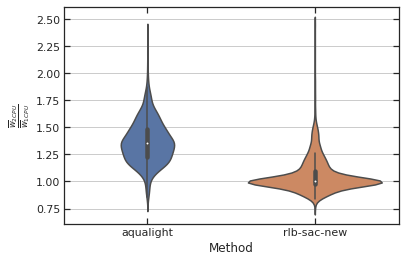

In [265]:
sns.violinplot(x='Method', y=ratio_str, data=df_ratio.loc[df_ratio['Ratio Type'] == 'Server Weights'])

Text(0, 0.5, '#Apache Thread Ratio')

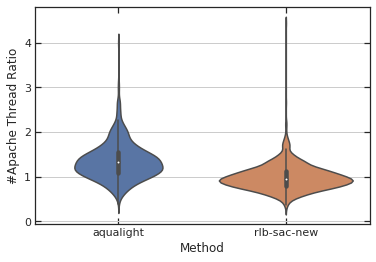

In [268]:
sns.violinplot(x='Method', y=ratio_str, data=df_ratio.loc[df_ratio['Ratio Type'] == 'Apache'])
plt.ylabel("#Apache Thread Ratio")

## Check FCT by episode

In [63]:
method = 'rlb-sac-new'

In [77]:
fig_dir

'../../data/figures/atc'

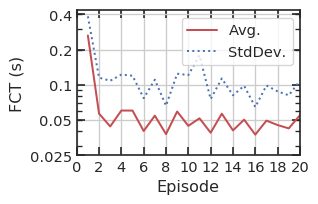

In [76]:
n_ep = 30

fig = plt.figure(figsize=(3,2), dpi=96)

fct_mean = []
fct_std = []
for ep in range(n_ep):
    if ep in [4,5,6,8,11,18,22,23,24,27]: continue
    fct_mean.append(np.mean(page_load_time_res[0][method]['plt_by_ep']['all'][ep]))
    fct_std.append(np.std(page_load_time_res[0][method]['plt_by_ep']['all'][ep]))
    
fct_mean = np.array(fct_mean)
fct_std = np.array(fct_std)
plt.plot(range(1, 20+1), fct_mean, '-', color='r', linewidth=1.5, label='Avg.')
plt.plot(range(1, 20+1), fct_std, ':', color='b', linewidth=1.5, label='StdDev.')
    # plt.plot(0, 0, color='b', label='Reward')
plt.legend()
# plt.ylim([-0.4, 0.])
plt.yscale('log')
plt.xticks(range(0, 22, 2))
plt.yticks([0.025, 0.05, 0.1, 0.2, 0.4], [0.025, 0.05, 0.1, 0.2, 0.4])
plt.xlim([0, 20])
plt.xlabel('Episode')
plt.ylabel('FCT (s)')
plt.show()
fig.savefig(os.path.join(fig_dir, 'rlb-fct-train.pdf'), bbox_inches='tight', transparent=True)

## Extension

In [129]:
def run_pipeline_test(
    lb_method = 'wcmp',
    trace='wiki_600',
    experiment='atc-lb',
    sample='hour0.csv',
    from_orig=True,
    config_file_prefix='1lb-conf01',
    colocate=None,
    colocate_freq=0.0001,
    twist=False,
    clip_n=20000,
    remote_servers = [0],
    eps = range(3)):
    server_id = 1
    if twist:
        config_file_prefix += '-twist'
    config_file = config_file_prefix+'-'+str(server_id)
    # config_file_remote = {i: config_file_prefix+'-{}'.format(i) for i in [0, 2, 3]}
    config_file_remote = {i: config_file_prefix+'-{}'.format(i) for i in remote_servers}

    ip_remote = tu.COMMON_CONF['net']['physical_server_ip']


    task_name, task_dir, nodes = tu.init_task_info(
        experiment=experiment,
        lb_method=lb_method,
        trace=trace,
        sample=sample,
        filename=config_file+'.json',
        colocate=colocate,
        colocate_freq=colocate_freq,
        alias=config_file_prefix
    )

    print(">> run task {}".format(task_name))
    
    for server_id in remote_servers:
        if clip_n and server_id == 0:
            clip_str = '-n {}'.format(clip_n)
        else:
            clip_str = ''

        cmd = 'ssh -t yzy@{} "python3 /home/yzy/Load-Balancer/src/utils/run2server.py --experiment {} --colocate-freq {} -m {} --tr {} --sample {} -f {}.json {}"'.format(
            ip_remote[server_id], experiment, colocate_freq, 'ecmp', trace, sample, config_file_remote[server_id], clip_str)

        tu.subprocess.Popen(cmd, shell=True)
    
    tu.prepare_img(lb_method=lb_method, from_orig=from_orig, debug_node=False)

    tu.runall()
    time.sleep(10)
    
    # run different episodes
    for ep in eps:
        print("== episode {} ==".format(ep))
        net_ok = False
        while not net_ok:
            try:
                tu.gt_socket_check()
                net_ok = True
            except:
                print('error')
                time.sleep(1)
                
        if 'rlb' in lb_method:
            for lb in tu.NODES['lb']:
                cmd = 'scp -i ~/.ssh/lb_rsa -oStrictHostKeyChecking=no -P {0} -r {1}/{3}_{2}_ep29 cisco@{4}:~/{2};'.format(
                    lb.ssh_port, '/home/yzy/Load-Balancer/data/results/atc-lb/wiki_600/rlb-sac-new/hour0-1lb-conf01', 'rl', lb.id, lb.physical_server_ip)
                tu.subprocess_cmd(cmd)
        # start gathering at LB node
        for lb in tu.NODES['lb']:
            lb.run_init_bg()

        # run traffic
        t0 = time.time()
        cmd = 'ssh -t yzy@10.60.16.12 "python3 /home/yzy/Load-Balancer/src/utils/run_traffic.py --experiment {} --colocate-freq {} -m {} --tr {} --sample {} -f {}.json"'.format(
            experiment, colocate_freq, lb_method, trace, sample, config_file_remote[0])
        if colocate:
            cmd += ' --colocate {}'.format(colocate)

        tu.subprocess_cmd(cmd)
        print("Trace replay over w/ total time: {:.3f}s".format(time.time()-t0))
        # time.sleep(5)

        # fetch results from nodes
        for server_id in remote_servers:
            cmd = 'ssh -t yzy@{} "python3 /home/yzy/Load-Balancer/src/utils/shutdown2server.py --experiment {} --colocate-freq {} -m {} --tr {} --sample {} -f {}.json --episode {}"'.format(
                ip_remote[server_id], experiment, colocate_freq, lb_method, trace, sample, config_file_remote[server_id], ep)
            if ep == eps[-1]:
                cmd += ' --shutdown'
            tu.subprocess.Popen(cmd, shell=True)

        for lb in tu.NODES['lb']:
            lb.fetch_result(task_dir, ep)
            if 'rlb' in lb_method:
                lb.fetch_result(task_dir, ep, filename='rl')
            lb.shutdown()

        tu.prepare_img(lb_method=lb_method, from_orig=None, debug_node=False)
        for lb in tu.NODES['lb']:
            lb.run()
        tu.host_br_up()
    tu.shutall()

In [130]:
methods = ['ecmp', 'active-wcmp', 'aqualight', 'wcmp', 'rlb-sac-new-test']
samples = ['hour{}.csv'.format(i) for i in range(20, 24, 2)]
config_prefix_list = ['1lb-conf01']
from_orig=False

In [39]:
for method in methods:
    for sample in samples:
        for config_prefix in config_prefix_list:
            run_pipeline_test(
                lb_method=method,
                trace='wiki_600',
                experiment='atc-lb',
                sample=sample,
                from_orig=from_orig,
                config_file_prefix=config_prefix,
                colocate=None,
                colocate_freq=0.0001,
                twist=False,
                clip_n=30000,
                remote_servers = [0],
                eps = range(5))

init_task_info: alias=1lb-conf01
alias=1lb-conf01
>> run task wiki_600-ecmp-hour20-1lb-conf01
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
node_server_0 ready: ssh -p 9000 cisco@localhost
node_server_1 ready: ssh -p 9001 cisco@localhost
node_server_2 ready: ssh -p 9002 cisco@localhost
node_server_3 ready: ssh -p 9003 cisco@localhost
node_server_4 ready: ssh -p 9004 cisco@localhost
node_server_5 ready: ssh -p 9005 cisco@localhost
node_server_6 ready: ssh -p 9006 cisco@localhost
== episode 0 ==
LB Node 0: pass
Trace replay over w/ total time: 80.958s
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
== episode 1 ==
LB Node 0: pass
Trace replay over w/ total time: 81.209s
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
== episode 2 ==
LB Node 0: pass
Trace replay over w/ total time: 76.930s
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
== episode 3 ==
LB Node 0: pass
Trace replay over w/ total time: 79.

node_lb_0 ready: ssh -p 8900 cisco@localhost
== episode 3 ==
LB Node 0: pass
Trace replay over w/ total time: 44.060s
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
== episode 4 ==
LB Node 0: pass
Trace replay over w/ total time: 44.492s
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
init_task_info: alias=1lb-conf01
alias=1lb-conf01
>> run task wiki_600-wcmp-hour22-1lb-conf01
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
node_server_0 ready: ssh -p 9000 cisco@localhost
node_server_1 ready: ssh -p 9001 cisco@localhost
node_server_2 ready: ssh -p 9002 cisco@localhost
node_server_3 ready: ssh -p 9003 cisco@localhost
node_server_4 ready: ssh -p 9004 cisco@localhost
node_server_5 ready: ssh -p 9005 cisco@localhost
node_server_6 ready: ssh -p 9006 cisco@localhost
== episode 0 ==
LB Node 0: pass
Trace replay over w/ total time: 45.057s
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
== episode 1 ==
LB Node

In [314]:
for method in ['rlb-sac-new-test']:
    for sample in ['hour22.csv']:
        for config_prefix in config_prefix_list:
            run_pipeline_test(
                lb_method=method,
                trace='wiki_600',
                experiment='atc-lb',
                sample=sample,
                from_orig=from_orig,
                config_file_prefix=config_prefix,
                colocate=None,
                colocate_freq=0.0001,
                twist=False,
                clip_n=30000,
                remote_servers = [0],
                eps = range(5))

init_task_info: alias=1lb-conf01
alias=1lb-conf01
>> run task wiki_600-rlb-sac-new-test-hour22-1lb-conf01
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
node_server_0 ready: ssh -p 9000 cisco@localhost
node_server_1 ready: ssh -p 9001 cisco@localhost
node_server_2 ready: ssh -p 9002 cisco@localhost
node_server_3 ready: ssh -p 9003 cisco@localhost
node_server_4 ready: ssh -p 9004 cisco@localhost
node_server_5 ready: ssh -p 9005 cisco@localhost
node_server_6 ready: ssh -p 9006 cisco@localhost
== episode 0 ==
LB Node 0: pass
Trace replay over w/ total time: 42.919s
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
== episode 1 ==
LB Node 0: pass
Trace replay over w/ total time: 43.027s
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
== episode 2 ==
LB Node 0: pass
Trace replay over w/ total time: 42.930s
Create LB node image...
node_lb_0 ready: ssh -p 8900 cisco@localhost
== episode 3 ==
LB Node 0: pass
Trace replay over w/ tot

## Plot page load time

In [364]:
COLORS_DICT = {
    'hlb': "#3978af", 
    'rlb-sac-new-test': "#17b6c8", 
    'aqualight': '#559d3f',
    'lsq': "#aecde1",
    'lsq2': "#634295",
    'active-wcmp': "#a65d34",
    'wcmp': "#ef8532", 
    'ecmp': "#d1342b", 
}

MARKER_DICT = {
    'lsq2':       "+",
    'ecmp':       ".",
    'lsq':       "o",
    'hlb':    "^",
    'rlb-sac-new-test':    "x",
    'active-wcmp': "3",
    'wcmp':   ">",
    'aqualight':   "v",
}

LINESTYLE_DICT = {
    'lsq2':       "-",
    'active-wcmp': '-',
    'ecmp':       "-",
    'lsq':       "-",
    'hlb':    "-",
    'rlb-sac-new-test':    "-",
    'wcmp':   "-",
    'aqualight':   "-",
}

METHOD_MAPPER = {
    'hlb': "HLB", 
    'rlb-sac-new-test': "RLB", 
    'aqualight': 'AquaLB',
    'lsq': "LSQ",
    'lsq2': "LSQ2",
    'active-wcmp': "Active WCMP",
    'wcmp': "WCMP", 
    'ecmp': "ECMP", 
}

In [365]:
root_dir = "../../data/results/atc-lb/wiki_600"
root_dir = "../../data/results/atc-lb/backup"
fig_dir = "../../data/figures/atc"

In [366]:
methods = ['ecmp', 'wcmp', 'active-wcmp', 'rlb-sac-new-test']

conf = '1lb-conf01'
trace = 'wiki_600'

In [367]:
page_load_time_res = {}
for hour in range(2, 24, 2):
    config = 'hour{:d}-{}'.format(hour, conf)
    print("working on config:", config)
    page_load_time_res[hour] = {}
    for method in methods:
        print(">> loading method:", method)
        _task, _dir = get_task_name_dir(trace, method, config)
        page_load_time_res[hour][method] = get_page_load_time(_dir, verbose=True)

working on config: hour2-1lb-conf01
>> loading method: ecmp
parsing trace trace_ep0.log
plt all: mean - 2.0260 median - 0.3754 99p - 20.0685
plt wiki: mean - 2.2590 median - 0.8495 99p - 20.4712
plt static: mean - 1.8351 median - 0.1508 99p - 19.4753
parsing trace trace_ep1.log
plt all: mean - 2.3557 median - 0.5948 99p - 31.4758
plt wiki: mean - 2.5518 median - 0.7471 99p - 31.5008
plt static: mean - 2.1954 median - 0.4517 99p - 31.4582
parsing trace trace_ep2.log
plt all: mean - 2.8244 median - 0.5805 99p - 32.6546
plt wiki: mean - 3.0689 median - 0.8386 99p - 32.8770
plt static: mean - 2.6237 median - 0.3999 99p - 32.5639
parsing trace trace_ep3.log
plt all: mean - 2.7396 median - 0.7831 99p - 31.8088
plt wiki: mean - 3.0439 median - 1.0457 99p - 32.1329
plt static: mean - 2.4900 median - 0.6196 99p - 31.6648
parsing trace trace_ep4.log
plt all: mean - 2.4493 median - 0.6766 99p - 31.5391
plt wiki: mean - 2.6568 median - 0.9044 99p - 31.6138
plt static: mean - 2.2789 median - 0.5381

plt wiki: mean - 2.3549 median - 0.5009 99p - 24.8230
plt static: mean - 2.1482 median - 0.2280 99p - 31.4776
parsing trace trace_ep4.log
plt all: mean - 3.1706 median - 0.8783 99p - 32.7811
plt wiki: mean - 3.3407 median - 1.2441 99p - 32.7518
plt static: mean - 3.0273 median - 0.5553 99p - 32.7884
>> loading method: wcmp
parsing trace trace_ep0.log
plt all: mean - 0.3315 median - 0.1397 99p - 1.9725
plt wiki: mean - 0.5253 median - 0.3303 99p - 2.1596
plt static: mean - 0.1686 median - 0.0110 99p - 0.8256
parsing trace trace_ep1.log
plt all: mean - 3.4227 median - 0.8660 99p - 33.0543
plt wiki: mean - 3.6914 median - 1.1485 99p - 33.4643
plt static: mean - 3.1964 median - 0.6116 99p - 32.7740
parsing trace trace_ep2.log
plt all: mean - 0.6877 median - 0.0265 99p - 18.8888
plt wiki: mean - 0.7973 median - 0.1110 99p - 20.3375
plt static: mean - 0.5954 median - 0.0021 99p - 18.4562
parsing trace trace_ep3.log
plt all: mean - 1.5928 median - 0.0999 99p - 37.1791
plt wiki: mean - 1.8026 

plt all: mean - 0.0313 median - 0.0109 99p - 0.2235
plt wiki: mean - 0.0617 median - 0.0491 99p - 0.2644
plt static: mean - 0.0031 median - 0.0020 99p - 0.0188
parsing trace trace_ep4.log
plt all: mean - 0.0301 median - 0.0110 99p - 0.2048
plt wiki: mean - 0.0590 median - 0.0490 99p - 0.2396
plt static: mean - 0.0031 median - 0.0020 99p - 0.0169
>> loading method: active-wcmp
parsing trace trace_ep0.log
plt all: mean - 0.0592 median - 0.0148 99p - 0.5003
plt wiki: mean - 0.1075 median - 0.0653 99p - 0.6022
plt static: mean - 0.0143 median - 0.0021 99p - 0.2624
parsing trace trace_ep1.log
plt all: mean - 0.0438 median - 0.0132 99p - 0.3341
plt wiki: mean - 0.0836 median - 0.0575 99p - 0.3970
plt static: mean - 0.0068 median - 0.0020 99p - 0.1066
parsing trace trace_ep2.log
plt all: mean - 0.0405 median - 0.0128 99p - 0.3168
plt wiki: mean - 0.0774 median - 0.0545 99p - 0.3901
plt static: mean - 0.0060 median - 0.0020 99p - 0.1250
parsing trace trace_ep3.log
plt all: mean - 0.0414 median

parsing trace trace_ep0.log
plt all: mean - 0.0537 median - 0.0156 99p - 0.3995
plt wiki: mean - 0.0982 median - 0.0641 99p - 0.4631
plt static: mean - 0.0100 median - 0.0021 99p - 0.1631
parsing trace trace_ep1.log
plt all: mean - 0.0567 median - 0.0150 99p - 0.5735
plt wiki: mean - 0.1012 median - 0.0570 99p - 0.7690
plt static: mean - 0.0132 median - 0.0021 99p - 0.2659
parsing trace trace_ep2.log
plt all: mean - 0.0428 median - 0.0139 99p - 0.3324
plt wiki: mean - 0.0793 median - 0.0527 99p - 0.3926
plt static: mean - 0.0071 median - 0.0020 99p - 0.1062
parsing trace trace_ep3.log
plt all: mean - 0.0418 median - 0.0143 99p - 0.3254
plt wiki: mean - 0.0776 median - 0.0525 99p - 0.3858
plt static: mean - 0.0067 median - 0.0020 99p - 0.1039
parsing trace trace_ep4.log
plt all: mean - 0.0405 median - 0.0138 99p - 0.3123
plt wiki: mean - 0.0752 median - 0.0519 99p - 0.3655
plt static: mean - 0.0064 median - 0.0020 99p - 0.0939
>> loading method: rlb-sac-new-test
parsing trace trace_ep0.

plt all: mean - 2.6175 median - 0.9649 99p - 31.5714
plt wiki: mean - 2.7514 median - 1.0340 99p - 31.6272
plt static: mean - 2.5035 median - 0.9185 99p - 31.5270
parsing trace trace_ep4.log
plt all: mean - 2.4286 median - 0.7566 99p - 31.4859
plt wiki: mean - 2.6488 median - 1.0837 99p - 31.5316
plt static: mean - 2.2412 median - 0.4550 99p - 31.4288
>> loading method: rlb-sac-new-test
parsing trace trace_ep0.log
plt all: mean - 0.0995 median - 0.0165 99p - 1.0864
plt wiki: mean - 0.1988 median - 0.1025 99p - 1.2876
plt static: mean - 0.0150 median - 0.0019 99p - 0.2307
parsing trace trace_ep1.log
plt all: mean - 0.0674 median - 0.0106 99p - 1.1986
plt wiki: mean - 0.1177 median - 0.0601 99p - 1.3499
plt static: mean - 0.0246 median - 0.0018 99p - 1.0021
parsing trace trace_ep2.log
plt all: mean - 0.0763 median - 0.0123 99p - 1.6145
plt wiki: mean - 0.1265 median - 0.0599 99p - 1.7511
plt static: mean - 0.0335 median - 0.0019 99p - 1.4273
parsing trace trace_ep3.log
plt all: mean - 0.

parsing trace trace_ep0.log
plt all: mean - 0.2071 median - 0.0619 99p - 1.4901
plt wiki: mean - 0.4070 median - 0.2696 99p - 1.6825
plt static: mean - 0.0468 median - 0.0024 99p - 0.4264
parsing trace trace_ep1.log
plt all: mean - 0.1573 median - 0.0271 99p - 1.5257
plt wiki: mean - 0.2821 median - 0.1220 99p - 1.8519
plt static: mean - 0.0568 median - 0.0020 99p - 0.6110
parsing trace trace_ep2.log
plt all: mean - 0.0425 median - 0.0039 99p - 0.3452
plt wiki: mean - 0.0909 median - 0.0613 99p - 0.4281
plt static: mean - 0.0037 median - 0.0018 99p - 0.0425
parsing trace trace_ep3.log
plt all: mean - 0.0385 median - 0.0040 99p - 0.3267
plt wiki: mean - 0.0822 median - 0.0572 99p - 0.4398
plt static: mean - 0.0035 median - 0.0018 99p - 0.0371
parsing trace trace_ep4.log
plt all: mean - 0.0616 median - 0.0122 99p - 0.6681
plt wiki: mean - 0.1182 median - 0.0664 99p - 0.8455
plt static: mean - 0.0162 median - 0.0019 99p - 0.3246


=== hour 20 ===
=== hour 22 ===


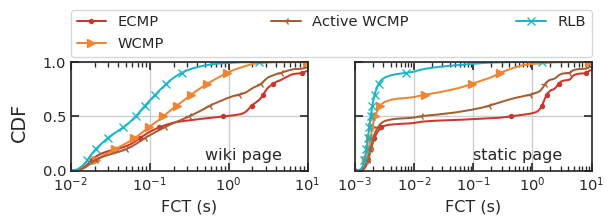

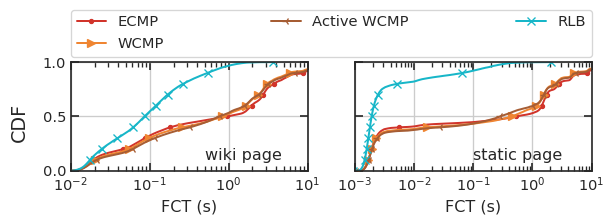

In [368]:
# xlims=[[1e-2, 3],[1e-2, 10]]
xlims=[[1e-2, 10],[1e-3, 10]]
n_subplots = 2
# xlim=None
for hour in range(20, 24, 2):
    print("=== hour {} ===".format(hour))
    fig, axs = plt.subplots(1, n_subplots, figsize=(7, 1.5), dpi=96, sharex=False, sharey=True)
    fig.suptitle('CDF', position=(0.048, .6), rotation='vertical')
    for i, ylabel, xlim in zip(range(n_subplots), ['wiki', 'static'], xlims):
        for method in methods:
            v = np.concatenate(page_load_time_res[hour][method]['plt_by_ep'][ylabel])
            color = COLORS_DICT[method]
            marker = MARKER_DICT[method]
            linestyle = LINESTYLE_DICT[method]
            percentiles = [np.percentile(v, p) for p in range(0, 110, 10)]
            axs[i].semilogx(np.sort(v), np.linspace(0, 1, len(v), endpoint=False), linestyle=linestyle, color=color)
            axs[i].semilogx(percentiles, np.linspace(0, 1, 11, endpoint=True), linestyle='', marker=marker, color=color)
            axs[i].plot([0.], [0.], linestyle=linestyle, marker=marker, color=color, label=METHOD_MAPPER[method])

        axs[i].set_xlim(xlim)
        axs[i].set_ylim([0.,1.])
        axs[i].grid(True)
        plt.sca(axs[i])
        if i == 0:
            plt.text(0.5, 0.1, '{} page'.format(ylabel))
        else:
            plt.text(0.1, 0.1, '{} page'.format(ylabel))


    #     axs[i].set_title()
        axs[i].set_xlabel('FCT (s)')
        if i == 0: axs[i].legend(bbox_to_anchor=(0., 1.05, 2.2, .102), loc='lower left',
               ncol=3, mode="expand", borderaxespad=0.)

    fig.savefig(os.path.join(fig_dir, 'rlb-wiki-hour{}.pdf'.format(hour)), bbox_inches='tight', transparent=True)
# axs[i].set_xlabel("FCT (s)")

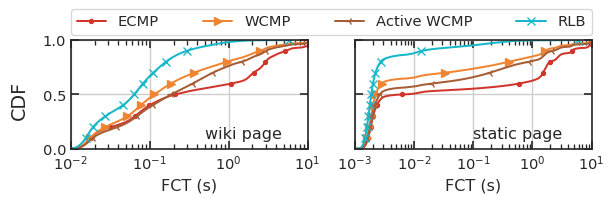

In [398]:
# xlims=[[1e-2, 3],[1e-2, 10]]
xlims=[[1e-2, 10],[1e-3, 10]]
n_subplots = 2
# xlim=None
fig, axs = plt.subplots(1, n_subplots, figsize=(7, 1.5), dpi=96, sharex=False, sharey=True)
fig.suptitle('CDF', position=(0.048, .6), rotation='vertical')
for i, ylabel, xlim in zip(range(n_subplots), ['wiki', 'static'], xlims):
    for method in methods:
#         v = np.concatenate([page_load_time_res[hour][method]['plt_{}'.format(ylabel)] for hour in hours if traffic_rates[hour] > 500 and hour < 22])
        v = np.concatenate([page_load_time_res[hour][method]['plt_{}'.format(ylabel)] for hour in hours if traffic_rates[hour] > 500])

        color = COLORS_DICT[method]
        marker = MARKER_DICT[method]
        linestyle = LINESTYLE_DICT[method]
        percentiles = [np.percentile(v, p) for p in range(0, 110, 10)]
        axs[i].semilogx(np.sort(v), np.linspace(0, 1, len(v), endpoint=False), linestyle=linestyle, color=color)
        axs[i].semilogx(percentiles, np.linspace(0, 1, 11, endpoint=True), linestyle='', marker=marker, color=color)
        axs[i].plot([0.], [0.], linestyle=linestyle, marker=marker, color=color, label=METHOD_MAPPER[method])

    axs[i].set_xlim(xlim)
    axs[i].set_ylim([0.,1.])
    axs[i].grid(True)
    plt.sca(axs[i])
    if i == 0:
        plt.text(0.5, 0.1, '{} page'.format(ylabel))
    else:
        plt.text(0.1, 0.1, '{} page'.format(ylabel))


#     axs[i].set_title()
    axs[i].set_xlabel('FCT (s)')
    if i == 0: axs[i].legend(bbox_to_anchor=(0., 1.05, 2.2, .102), loc='lower left',
           ncol=4, mode="expand", borderaxespad=0.)

fig.savefig(os.path.join(fig_dir, 'application', 'lb', 'rlb-wiki-cdf.pdf'), bbox_inches='tight', transparent=True)
# axs[i].set_xlabel("FCT (s)")

In [371]:
methods_ratio = ['aqualight', 'rlb-sac-new-test']
hours = range(2, 24, 2)
config_fmt = "hour{}-1lb-conf01"
split_by = 3
ratio_str = r"$\frac{\overline{w}_{2CPU}}{\overline{w}_{1CPU}}$"
df_dict = {
    ratio_str: [],
    'Ratio Type': [],
    'Time': [],
    'Method': [],
    'Hour': []
}

In [372]:
for method in methods_ratio:
    for hour in hours:
        conf = config_fmt.format(hour)
        for ep in range(5):
            filename = "../../data/results/atc-lb/wiki_600/{}/{}/0_log_ep{}/logger.log".format(method, conf, ep)
            if not os.path.exists(filename): continue
            lines = read_file(filename)
            lines = lines[int(0.25*len(lines)):int(0.75*len(lines))]
            for l in lines:
                if "Time: " in l:
                    t = float(l.split('Time: ')[-1].strip(" ").strip("s)"))
                if '#apache: ' in l:
                    values = [int(n) for n in l.split('#apache:')[-1].split('|')]
                    df_dict[ratio_str].append(np.mean(values[:split_by])/(1e-6+np.mean(values[split_by:])))
                    df_dict['Ratio Type'].append('Apache')
                    df_dict['Time'].append(t)
                    df_dict['Method'].append(method)
                    df_dict['Hour'].append(hour)
                elif 'Last action: ' in l:
                    values = [float(n) for n in l.split('Last action:')[-1].split('|')]
                    df_dict[ratio_str].append(np.mean(values[:split_by])/(np.mean(values[split_by:])+1e-6))
                    df_dict['Ratio Type'].append('Server Weights')
                    df_dict['Time'].append(t)
                    df_dict['Method'].append(method)
                    df_dict['Hour'].append(hour)
                else:
                    continue

In [373]:
df_ratio = pd.DataFrame.from_dict(df_dict)

In [374]:
wc_lines = !wc -l ../../data/trace/wiki_600/*

traffic_rates = {}
for l in wc_lines:
    if 'hour' in l:
        n_line, hour = l.strip(' ').split(' ../../data/trace/wiki_600/hour')
        traffic_rates[int(hour.replace('.csv', ''))] = int(n_line)

In [375]:
filename = "../../data/trace/wiki_600/hour{}.csv".format(hour)

In [376]:
n_lines = 100000
for hour in hours:
    filename = "../../data/trace/wiki_600/hour{}.csv".format(hour)
    l0 = !sed "1q;d" {filename}
    ln = !sed "100000q;d" {filename}
    dt = float(ln[0].split('\t')[0]) - float(l0[0].split('\t')[0])
    traffic_rates[hour] = n_lines/dt

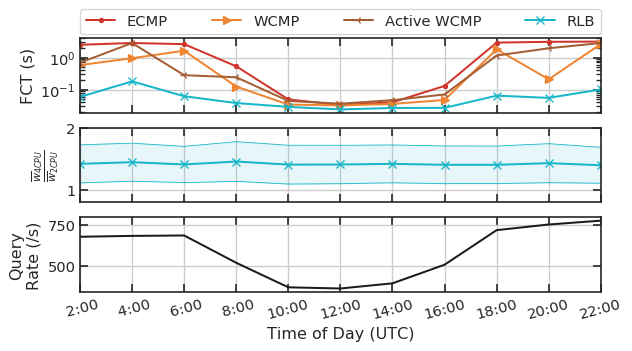

In [401]:
hours = range(2, 24, 2)
fig, axs = plt.subplots(3, 1, figsize=(7, 3.5), dpi=96, sharex=True, sharey=False)

# first plot FCT
for method in methods:
    color = COLORS_DICT[method]
    marker = MARKER_DICT[method]
    linestyle = LINESTYLE_DICT[method]
    v = []
    for hour in hours:
        v.append(np.mean(page_load_time_res[hour][method]['page_load_time']))
    axs[0].semilogy(hours, v, color=color, marker=marker, label=METHOD_MAPPER[method])
    axs[0].legend(bbox_to_anchor=(0., 1.05, 1., .102), loc='lower left',
               ncol=4, mode="expand", borderaxespad=0.)
axs[0].set_ylabel('FCT (s)')


i = 1
# then plot weight ratio
for method in methods_ratio:
    if 'aqualight' in method: continue
    color = COLORS_DICT[method]
    marker = MARKER_DICT[method]
    linestyle = LINESTYLE_DICT[method]
    v = []
    std = []
    for hour in hours:
        values = df_ratio.loc[(df_ratio['Method']==method)&(df_ratio['Hour']==hour)&(df_ratio['Ratio Type']=='Server Weights')][ratio_str].values
        v.append(values.mean())
        std.append(values.std())
    v = np.array(v)
    std = np.array(std)
    axs[i].fill_between(hours, v+std, v-std, color=color, alpha=0.1)
    axs[i].plot(hours, v, color=color, marker=marker)
    axs[i].plot(hours, v+std, color=color, linewidth=0.6)
    axs[i].plot(hours, v-std, color=color, linewidth=0.6)
axs[i].set_ylim(0.8, 2)
axs[i].set_ylabel(r"$\frac{\overline{w}_{4CPU}}{\overline{w}_{2CPU}}$")

i=2
# plot traffic rates
axs[i].plot(hours, [traffic_rates[h] for h in hours], 'k')
axs[i].set_ylabel("Query\nRate (/s)")


plt.xlim([hours[0], hours[-1]])
plt.xticks(hours, ['{:2d}:00'.format(h) for h in hours], rotation=15)
plt.xlabel("Time of Day (UTC)")
plt.show()
fig.savefig(os.path.join(fig_dir, 'application', 'lb', 'timeline.pdf'.format(hour)), bbox_inches='tight', transparent=True)

In [378]:
methods_ratio = ['aqualight', 'rlb-sac-new-test']
hours = range(2, 24, 2)
config_fmt = "hour{}-1lb-conf01"
split_by = 3
df_dict = {
    'AS Group': [],
    '#Apache': [],
    'Method': [],
    'Hour': []
}

In [379]:
for method in methods_ratio:
    for hour in hours:
        conf = config_fmt.format(hour)
        for ep in range(5):
            filename = "../../data/results/atc-lb/wiki_600/{}/{}/0_log_ep{}/logger.log".format(method, conf, ep)
            if not os.path.exists(filename): continue
            lines = read_file(filename)
            lines = lines[int(0.25*len(lines)):int(0.75*len(lines))]
            for l in lines:
                if "Time: " in l:
                    t = float(l.split('Time: ')[-1].strip(" ").strip("s)"))
                if '#apache: ' in l:
                    values = [int(n) for n in l.split('#apache:')[-1].split('|')]
                    n_apache0 = np.mean(values[:split_by])
                    n_apache1 = np.mean(values[split_by:])
                    df_dict['#Apache'].append(n_apache0)
                    df_dict['AS Group'].append('4-CPU')
                    df_dict['Method'].append(METHOD_MAPPER[method])
                    df_dict['Hour'].append(hour)
                    df_dict['#Apache'].append(n_apache1)
                    df_dict['AS Group'].append('2-CPU')
                    df_dict['Method'].append(METHOD_MAPPER[method])
                    df_dict['Hour'].append(hour)
                else:
                    continue

In [380]:
df_apache = pd.DataFrame.from_dict(df_dict)

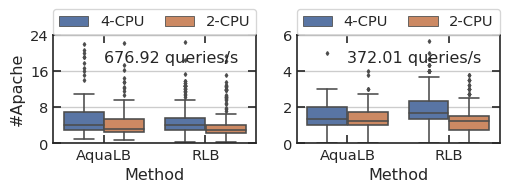

In [333]:
fig, axs = plt.subplots(1, 2, figsize=(6, 1.5), dpi=96)

# cpu_avg
plt.sca(axs[0])
sns.boxplot(x="Method", y="#Apache", hue="AS Group",
                  data=df_apache.loc[df_apache['Hour'] == 2], linewidth=1.2, fliersize=2)
# plt.xlabel('')
# plt.ylabel('')
plt.legend(bbox_to_anchor=(0., 1., 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)
plt.ylim([0, 24])
plt.yticks([0, 8, 16, 24], [0, 8, 16, 24])
plt.text(0, 18, '{:.2f} queries/s'.format(traffic_rates[2]))


plt.sca(axs[1])
sns.boxplot(x="Method", y="#Apache", hue="AS Group",
                  data=df_apache.loc[df_apache['Hour'] == 10], linewidth=1.2, fliersize=2)
# plt.xlabel('')
# plt.ylabel('')
plt.legend(bbox_to_anchor=(0., 1., 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)
plt.ylim([0, 6])
plt.text(0, 4.5, '{:.2f} queries/s'.format(traffic_rates[10]))

plt.ylabel('')
fig.savefig(os.path.join(fig_dir, 'application/lb', 'apache.pdf'), bbox_inches='tight', transparent=True)

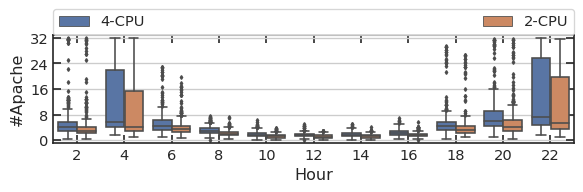

In [397]:
fig = plt.figure(figsize=(7, 1.5), dpi=96)

# cpu_avg
sns.boxplot(x="Hour", y="#Apache", hue="AS Group",
                  data=df_apache.loc[df_apache['Method'] == 'RLB'], linewidth=1.2, fliersize=2)
# plt.xlabel('')
# plt.ylabel('')
plt.legend(bbox_to_anchor=(0., 1., 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)
plt.ylim([-1, 33])
plt.yticks([0, 8, 16, 24, 32], [0, 8, 16, 24, 32])
# plt.text(0, 18, '{:.2f} queries/s'.format(traffic_rates[2]))


fig.savefig(os.path.join(fig_dir, 'application/lb', 'apache.pdf'), bbox_inches='tight', transparent=True)

In [344]:
df_apache.head()

,AS Group,#Apache,Method,Hour
0,4-CPU,31.333333,AquaLB,2
1,2-CPU,29.000000,AquaLB,2
2,4-CPU,31.333333,AquaLB,2
3,2-CPU,31.750000,AquaLB,2
4,4-CPU,30.666667,AquaLB,2


In [347]:
for hour in [2, 10]:
    for method in ['AquaLB', 'RLB']:
        print("hour {} - method {}: ratio {:.3f}".format(hour, method, 
                                                         df_apache.loc[(df_apache['Hour'] == hour)&(df_apache['Method'] == method)&(df_apache['AS Group'] == '4-CPU')]['#Apache'].mean()/df_apache.loc[(df_apache['Hour'] == hour)&(df_apache['Method'] == method)&(df_apache['AS Group'] == '2-CPU')]['#Apache'].mean()
                                                        ))

hour 2 - method AquaLB: ratio 1.183
hour 2 - method RLB: ratio 1.258
hour 10 - method AquaLB: ratio 1.102
hour 10 - method RLB: ratio 1.523


# Overhead analysis

In [387]:
def get_cpu_mem_overhead(filename, ts_range=300, warmup=0.2, cooldown=0.8, memsize=4.039104, verbose=True):
    df = pd.DataFrame.from_csv(filename).reset_index()
    df = df.loc[df.ts < ts_range].reset_index()
    df = df.iloc[int(len(df)*warmup):int(len(df)*cooldown)]
    cpu_list = df.cpu_usage.values
    mem_list = df.used_ram.values*memsize/100
    if verbose:
        print("average cpu {:.3f}% mem {:.3f}GiB".format(cpu_list.mean(), mem_list.mean()))
    return cpu_list, mem_list

In [391]:
overhead = {}
data_dir = '../../data/results/atc-lb/backup'
n_ep = 5
conf_fmt = 'hour{}-1lb-conf01'

In [ ]:
for method in methods:
    print("=== method {} ===".format(method))
    overhead[method] = {
            'cpu': [],
            'mem': [],
        }
    for hour in hours:
        conf = conf_fmt.format(hour)
        for ep in range(n_ep):
            filename = "{}/{}/{}/{}_log_ep{}/usage.log".format(data_dir, method, conf, 0, ep)
            if os.path.exists(filename):
                cpu_list, mem_list = get_cpu_mem_overhead(filename)
                overhead[method]['cpu'].append(cpu_list)
                overhead[method]['mem'].append(mem_list)
            else:
                print("ep {} doesn't exist".format(ep))
    overhead[method]['cpu'] = [item for sublist in overhead[method]['cpu'] for item in sublist]
    overhead[method]['mem'] = [item for sublist in overhead[method]['mem'] for item in sublist]

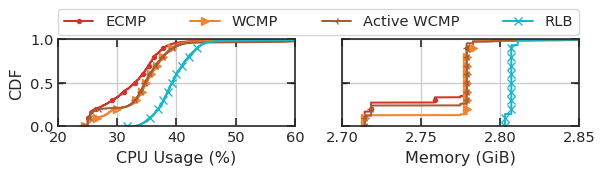

In [402]:
fig, axs = plt.subplots(1, 2, figsize=(7, 1.2), dpi=96, sharex=False, sharey=True)
# for i, (setup, xlim, title) in enumerate(zip(configs, [[5e-2, 2]]*3, ['#LB={}'.format(i) for i in [1, 2, 3]])):
for i, (metric, xlim) in enumerate(zip(['cpu', 'mem'], [[20, 60], [2.7, 2.85]])):

    for mode in methods:
        v = overhead[mode][metric]
        color = COLORS_DICT[mode]
        marker = MARKER_DICT[mode]
        percentiles = [np.percentile(v, p) for p in range(0, 110, 10)]
        axs[i].plot(np.sort(v), np.linspace(0, 1, len(v), endpoint=False), color=color)
        axs[i].plot(percentiles, np.linspace(0, 1, 11, endpoint=True), linestyle='', marker=marker, color=color)
        axs[i].plot([0.], [0.], marker=marker, color=color, label=METHOD_MAPPER[mode])

    axs[i].set_xlim(xlim)
    axs[i].set_ylim([0.,1.])
    axs[i].grid(True)
    if i == 0:
        plt.sca(axs[i])
        axs[i].legend(bbox_to_anchor=(0., 1.05, 2.2, .102), loc='lower left',
           ncol=4, mode="expand", borderaxespad=0.)
        axs[i].set_ylabel('CDF')
        axs[i].set_xlabel("CPU Usage (%)")
    else:
        axs[i].set_yticks([0.5], [''])
        axs[i].set_xlabel("Memory (GiB)")

    
    axs[i].set_xlim(xlim)
    axs[i].grid(True)

# i=2
# for mode in modes:
#     if mode in ['oracle']: continue
#     v = delays[mode]
#     color = COLORS_DICT[mode]
#     marker = MARKER_DICT[mode]
#     percentiles = [np.percentile(v, p) for p in range(0, 110, 10)]
#     axs[i].semilogx(np.sort(v), np.linspace(0, 1, len(v), endpoint=False), color=color)
#     axs[i].semilogx(percentiles, np.linspace(0, 1, 11, endpoint=True), linestyle='', marker=marker, color=color)
#     axs[i].plot([0.], [0.], marker=marker, color=color, label=METHOD_MAPPER[mode])

# axs[i].set_xlim(0.8,160)
# axs[i].set_ylim([0,1.])
# # axs[i].set_yscale('log')
# axs[i].grid(True)
# axs[i].set_yticks([0.5], [''])
# # axs[i].set_xticks([1, 10, 100], [1, 10, 100])
# axs[i].set_xlabel("Decision Delay (ms)")

fig.savefig('../../data/figures/atc/application/lb/overhead.pdf', bbox_inches='tight', transparent=True)

In [357]:
method = 'aqualight'
np.mean(overhead[method]['cpu']) / np.mean(overhead['ecmp']['cpu'])

1.0281475376596563

In [358]:
np.mean(overhead[method]['mem']) - np.mean(overhead['ecmp']['mem'])

-0.006445497721170312

In [394]:
clib_dict = {
}
for m in methods:
    clib_dict[m] = {
        0: [],
        1: [],
        2: []
    }
    for hour in hours:
        conf = conf_fmt.format(hour)
        for ep in range(n_ep):
            filename = "{}/{}/{}/{}_log_ep{}/clib.log".format(data_dir, m, conf, 0, ep)
            if os.path.exists(filename):
                lines = [l.split('@dt = ')[-1].strip(' ') for l in read_file(filename) if '@dt' in l]
                for l in lines:
                    dt, packet_type = float(l.split('|')[0].strip(']')), int(l.split('|')[1].strip(']'))
                    clib_dict[m][packet_type].append(dt)
            else:
                print("ep {} doesn't exist".format(ep))    

In [334]:
import matplotlib.patches as patches

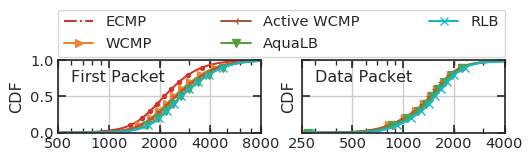

In [340]:
fig, axs = plt.subplots(1, 2, figsize=(6,1), dpi=96, sharex=False, sharey=True)
plt.sca(axs[0])
# plot with data as the data source
for m in methods:
    c, marker = COLORS_DICT[m], MARKER_DICT[m]
    data = clib_dict[m][0]
    percentiles = [np.percentile(data, p) for p in range(0, 110, 10)]
    plt.semilogx(np.sort(data), np.linspace(0, 1, len(data), endpoint=False), color=c)
    plt.semilogx(percentiles, np.linspace(0, 1, 11, endpoint=True), marker, color=c)
    plt.semilogx(0, -1, '-{}'.format(marker), color=c, label=METHOD_MAPPER[m])
plt.legend(bbox_to_anchor=(0., 1.05, 2.2, .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.)
# plt.grid()
plt.ylabel("CDF")
plt.text(600, 0.7, 'First Packet')
# plt.xscale('log')
plt.xlim([500, 8000])
plt.xticks([500, 1000, 2000, 4000, 8000], [500, 1000, 2000, 4000, 8000])

plt.sca(axs[1])
# plot with data as the data source
for m in methods:
    c, marker = COLORS_DICT[m], MARKER_DICT[m]
    data = clib_dict[m][1]
    percentiles = [np.percentile(data, p) for p in range(0, 110, 10)]
    plt.semilogx(np.sort(data), np.linspace(0, 1, len(data), endpoint=False), color=c)
    plt.semilogx(percentiles, np.linspace(0, 1, 11, endpoint=True), marker, color=c)
    plt.semilogx(0, -1, '-{}'.format(marker), color=c, label=METHOD_MAPPER[m])

# plt.xscale('log')
plt.text(300, 0.7, 'Data Packet')
plt.ylabel("CDF")
# plt.xlabel('Number of CPU Cycles Per Packet (Log Scale)')
# plt.grid()
plt.xlim([250, 4000])
plt.ylim([0, 1])
plt.xticks([250, 500, 1000, 2000, 4000], [250, 500, 1000, 2000, 4000])
fig.savefig(os.path.join('../../data/figures/atc/application/lb', 'latency.pdf'), bbox_inches='tight', transparent=True)

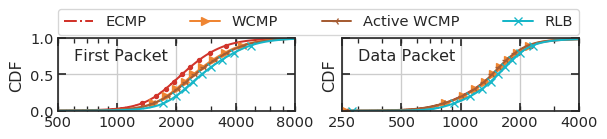

In [403]:
fig, axs = plt.subplots(1, 2, figsize=(7,1), dpi=96, sharex=False, sharey=True)
plt.sca(axs[0])
# plot with data as the data source
for m in methods:
    c, marker = COLORS_DICT[m], MARKER_DICT[m]
    data = clib_dict[m][0]
    percentiles = [np.percentile(data, p) for p in range(0, 110, 10)]
    plt.semilogx(np.sort(data), np.linspace(0, 1, len(data), endpoint=False), color=c)
    plt.semilogx(percentiles, np.linspace(0, 1, 11, endpoint=True), marker, color=c)
    plt.semilogx(0, -1, '-{}'.format(marker), color=c, label=METHOD_MAPPER[m])
plt.legend(bbox_to_anchor=(0., 1.05, 2.2, .102), loc='lower left',
           ncol=4, mode="expand", borderaxespad=0.)
# plt.grid()
plt.ylabel("CDF")
plt.text(600, 0.7, 'First Packet')
# plt.xscale('log')
plt.xlim([500, 8000])
plt.xticks([500, 1000, 2000, 4000, 8000], [500, 1000, 2000, 4000, 8000])

plt.sca(axs[1])
# plot with data as the data source
for m in methods:
    c, marker = COLORS_DICT[m], MARKER_DICT[m]
    data = clib_dict[m][1]
    percentiles = [np.percentile(data, p) for p in range(0, 110, 10)]
    plt.semilogx(np.sort(data), np.linspace(0, 1, len(data), endpoint=False), color=c)
    plt.semilogx(percentiles, np.linspace(0, 1, 11, endpoint=True), marker, color=c)
    plt.semilogx(0, -1, '-{}'.format(marker), color=c, label=METHOD_MAPPER[m])

# plt.xscale('log')
plt.text(300, 0.7, 'Data Packet')
plt.ylabel("CDF")
# plt.xlabel('Number of CPU Cycles Per Packet (Log Scale)')
# plt.grid()
plt.xlim([250, 4000])
plt.ylim([0, 1])
plt.xticks([250, 500, 1000, 2000, 4000], [250, 500, 1000, 2000, 4000])
fig.savefig(os.path.join('../../data/figures/atc/application/lb', 'latency.pdf'), bbox_inches='tight', transparent=True)

In [352]:
np.mean(clib_dict['rlb-sac-new-test'][0])- np.mean(clib_dict['ecmp'][0])

692.890628180478